# Sentiment analysis with RNN

In [2]:
import numpy as np
import scipy.sparse
import json
import zipfile as zip

import spacy
from keras.preprocessing import text, sequence
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser

import keras.backend as K
from keras.utils import to_categorical
from keras import models, optimizers, regularizers
from keras.layers import Dropout, Dense, Activation, Flatten, LSTM, \
Conv1D, MaxPooling1D, GRU, Embedding, CuDNNLSTM, Bidirectional

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Importing

Data is preprocessed as a list of lists, reviews are parsed and stop words and punctuation are removed.

In [2]:
# processed from gensim_walkthrough notebook
with open('../../data/processed/processed.txt', 'r') as f:
    restaurants = (json.loads(line) for line in f)

In [3]:
# different text cleaning for reviews
with open('../../data/processed/reviews_cleaned.txt', 'r') as f:
    reviews = tuple(json.loads(line) for line in f)

## Keras text processing example

In [50]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(['eat a lot, need to exercise more', "vegetables are good", "who likes chicken all the time"])


In [51]:
tokenizer.word_index

{'eat': 1,
 'a': 2,
 'lot': 3,
 'need': 4,
 'to': 5,
 'exercise': 6,
 'more': 7,
 'vegetables': 8,
 'are': 9,
 'good': 10,
 'who': 11,
 'likes': 12,
 'chicken': 13,
 'all': 14,
 'the': 15,
 'time': 16}

## Doing the same process with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [21]:
%%time
re_run=False
if re_run:
    # create dictionary
    dict_yelp = corpora.Dictionary(reviews)
    # tune corpus to get a smaller dictionary and doc_term matrix, 
    # embeddings will still work but bow will not fit into 8gb gpu memory otherwise
    dict_yelp.filter_extremes(no_below=40, keep_n=20000)
    dict_yelp.save('./processed/dictionary')

dict_yelp = corpora.Dictionary.load('../../data/processed/dictionary')    

CPU times: user 44.2 ms, sys: 19.8 ms, total: 64 ms
Wall time: 60.8 ms


In [19]:

bow = False
if bow:
    
    if re_run:
        # re-rerun after filtering dictionary only for bow model
        corpus = tuple(dict_yelp.doc2bow(review) for review in reviews)

        # save corpus
        corpora.MmCorpus.serialize('../../data/processed/corpus.mm', corpus)

    # load corpus
    corpus = corpora.MmCorpus('../../data/processed/corpus.mm')

In [56]:
# most common words
top_ids = sorted(dict_yelp.dfs.items(), key=lambda x: x[1], reverse=True)[0:30]
[(dict_yelp[item[0]], item[1]) for item in top_ids]

[('this', 240115),
 ('but', 234529),
 ('with', 212575),
 ('place', 204032),
 ('that', 201558),
 ('on', 194653),
 ('do', 176703),
 ('go', 167435),
 ('so', 159652),
 ('service', 155644),
 ('get', 152298),
 ('great', 151777),
 ('at', 146103),
 ('here', 139643),
 ('will', 131348),
 ('very', 126403),
 ('time', 124857),
 ('come', 122212),
 ('there', 121375),
 ('like', 119441),
 ('order', 117927),
 ('if', 115701),
 ('would', 115030),
 ('all', 113190),
 ('as', 112922),
 ('back', 110512),
 ('just', 109932),
 ('out', 109830),
 ('try', 102538),
 ('one', 101402)]

In [57]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys()) + 1
    
    for word in text:        
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_final)
    
    return processed[0:max_len]        

In [58]:
%%time
save = False
if save:
    
    corpus = [text_sequencer(dict_yelp, review) for review in reviews]
    corpus = sequence.pad_sequences(corpus, maxlen=200)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [59]:
# this is the converted corpus array, not from gensim
if save:
    np.save('../../data/processed/corpus.npy', corpus)
    
corpus = np.load('../../data/processed/corpus.npy')

In [60]:
# # no sorting
# def data_split(data, proportion = .2):
#     cutoff = round(len(data) * (1-proportion))
#     return data[0:cutoff], data[cutoff:]
    

## Integrating glove embeddings

In [61]:
def load_embeddings(emb_path = '/projects/embeddings/data/'):
    # load glove vectors
    embeddings_index={}
    with zip.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(keys, dict_yelp):
    
    embeddings_index = load_embeddings()
    conversion_table = {}
    for key in keys:
        if bytes(key, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[key]+1] = embeddings_index[bytes(key, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[key]+1] = np.random.randn(100)
    return conversion_table

In [62]:
%%time
conversion_table = id_to_glove(dict_yelp.token2id.keys(), dict_yelp)
embedding_matrix = np.vstack([conversion_table[key] for key in conversion_table.keys()])
embedding_matrix = np.vstack((np.zeros(100), embedding_matrix, np.random.randn(100)))

CPU times: user 16.2 s, sys: 125 ms, total: 16.3 s
Wall time: 16.3 s


## Compressed matrix creation

In [63]:
if bow:
    # skipped if not using bag-of-words or corpus fits into memory, uses gensim corpus object not list of lists
    matrix = corpus2csc(corpus, num_terms=len(dict_yelp.keys()), num_docs=490049, dtype=np.int16).T
    matrix = matrix.tocsr()
    matrix.shape
if save:
    scipy.sparse.save_npz('../../data/processed/corpus_matrix', matrix)

# matrix = scipy.sparse.load_npz('./processed/corpus_matrix.npz')

## Labels

In [64]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    else:
        return 0

In [65]:
stars = np.array([restaurant['stars'] for restaurant in restaurants])
stars = [convert_rating(star) for star in stars]

In [66]:
with open('../../data/numpy/ratings.npy', 'rb') as f:
    stars = np.load(f, allow_pickle=False)


In [67]:
train, val, train_y, val_y = train_test_split(corpus, stars, test_size = 0.2)

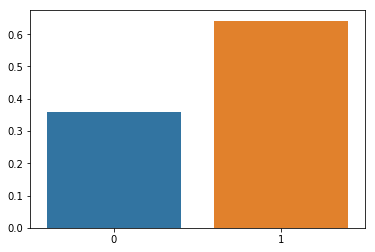

In [68]:
sns.barplot(x = stars, y = stars, estimator=lambda x: len(x)/len(stars))
plt.show()

## Generator function

In [69]:
# keras needs arrays as inputs, so .A reconverts a batch to the original numpy array

def get_batch(matrix, labels, bs):
    # matrix should be a document x word csr matrix
    i = 0
    while i < matrix.shape[0]/bs:
        yield matrix[i*bs:(i+1)*bs,].A, labels[i*bs:(i+1)*bs]
        i+=1  

In [70]:
if bow:
    generator = get_batch(matrix, stars, 32)
    review_lens = [len(review) for review in reviews]
    print(np.max(review_lens))
    print(np.min(review_lens))
    print(np.std(review_lens))
    print(np.median(review_lens))
    print(np.mean(review_lens))
    print(np.percentile(review_lens, 99.5))
    sns.distplot(review_lens)
    plt.show()

In [71]:
# originally written to cut review lengths, did this in gensim_walkthrough instead
def cut(review, cutoff=30):
    text = ''
    for i, word in enumerate(review):
        if i <= 30:
            if text == '':
                text = word
            else:    
                text += ' ' + word
    return text        

## Modeling 

In [72]:
# use if training for more categories
vocab_size = len(dict_yelp.keys())
assert corpus.shape == (490049, 200)
stars_cat = to_categorical(stars)

if save:
    with open('ratings.npy', 'wb') as f:
        np.save(f, stars)

In [73]:
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


In [74]:
# units for output size in Dense layer, vocab_size for number of features in nlp in Embedding 
# tried adding dropout but it lowered accuracy, shouldn't need it if it's not overfitting
def get_model():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Conv1D(100, 5))
    model.add(Conv1D(100, 3))
    model.add(MaxPooling1D(4))
    model.add(LSTM(67))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

#model = get_model()

In [75]:
def get_model2():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Bidirectional(CuDNNLSTM(67, return_sequences = True)))
    model.add(Bidirectional(CuDNNLSTM(67)))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [76]:
def get_model3():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(CuDNNLSTM(67))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
    model.summary()
    return model

## Training

In [77]:
model = get_model3()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          1258000   
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 67)                45292     
_________________________________________________________________
dense_3 (Dense)              (None, 31)                2108      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 32        
Total params: 1,305,432
Trainable params: 1,305,432
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.fit(train, train_y, batch_size=500, epochs=2, verbose=1, validation_split=0.2)

Train on 313631 samples, validate on 78408 samples
Epoch 1/2
313631/313631 [==============================] - 20s 64us/step - loss: 0.6569 - binary_crossentropy: 0.3626 - acc: 0.8355 - val_loss: 0.5262 - val_binary_crossentropy: 0.2878 - val_acc: 0.8783
Epoch 2/2
313631/313631 [==============================] - 19s 62us/step - loss: 0.4837 - binary_crossentropy: 0.2770 - acc: 0.8825 - val_loss: 0.4533 - val_binary_crossentropy: 0.2729 - val_acc: 0.8850


In [79]:
# # reset weights if necessary
# model.reset_states()

In [80]:
# adjust lr since val loss increases, seems to be going past minimum
K.set_value(model.optimizer.lr, 0.0001)


In [81]:
model.fit(train, train_y, batch_size=500, epochs=1, verbose=1, validation_split=0.2)

Train on 313631 samples, validate on 78408 samples
Epoch 1/1
313631/313631 [==============================] - 19s 62us/step - loss: 0.4288 - binary_crossentropy: 0.2505 - acc: 0.8950 - val_loss: 0.4460 - val_binary_crossentropy: 0.2699 - val_acc: 0.8865


In [82]:
if save:
    model.save('./models/lstm')

In [83]:
# from keras.models import load_model
# model = load_model('./models/test_ann')

## Evaluation

In [84]:
model.evaluate(val, val_y, batch_size=32, verbose=1)

98010/98010 [==============================] - 20s 208us/step


[0.4476934744428462, 0.2715314700875692, 0.8842363024181206]

In [85]:
model.metrics_names

['loss', 'binary_crossentropy', 'acc']

In [86]:
def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
   
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
        print('prob error is greater than 0.5 is %.4f' % cond_error)
        print('binary cross entropy is %.4f' % binary_cross_entropy)
    

/home/ryeyoo/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


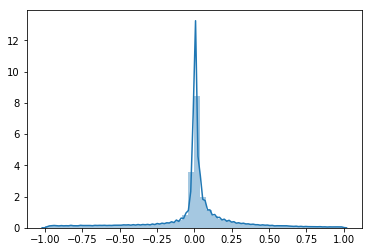

prob error is greater than 0.5 is 0.1158
binary cross entropy is -0.2715


In [87]:
evaluate(val, val_y)